In [ ]:
# data source: https://www.kaggle.com/jangot/ligue1-match-statistics
# the aim of this project is to predict whether the home team won, using match statistics

In [21]:
# clear all variables, functions, etc
%reset -f

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np #foundational package for scientific computing
import matplotlib as mpl #collection of functions for scientific and publication-ready visualization
import matplotlib.pyplot as plt
from IPython import display #pretty printing of dataframes in Jupyter notebook
import seaborn as sns #data visualization

print('All libraries loaded successfully')

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

# Fixing random state for reproducibility
np.random.seed(123)

All libraries loaded successfully


In [22]:
# import full dataset
full = pd.read_csv('../data/match_stats_top5leagues/FootballEurope.csv')

# view data type of each variable
print(full.info())

# drop some variables that we won't be using
full = full.drop(['match_id','awayTeamLineUp','homeTeamLineUp','refereeName','homeManagerName','awayManagerName','homeTeam','awayTeam','venueName','date'], axis=1)

# view levels of remaining object variables
for var in full.columns:
    if full[var].dtype=='object':
        print(full[var].value_counts())

# set up the target variable: dummy for home win
full['homewin']=0
full.loc[(full['homeGoalFT']>full['awayGoalFT']),'homewin']=1
full = full.drop(['homeGoalFT','awayGoalFT'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 93 columns):
match_id                   9127 non-null int64
homeTacklesTotalHT         9127 non-null int64
homeShotsTotalHT           9127 non-null int64
awayDispossessedFT         9126 non-null float64
awayPassSuccessFT          9127 non-null float64
awayRatingsFT              9127 non-null float64
awayDribbleSuccessFT       9125 non-null float64
awayDribblesAttemptedHT    9127 non-null int64
awayTeamLineUp             9127 non-null object
awayShotsBlockedHT         8906 non-null float64
awayShotsTotalHT           9126 non-null float64
homeDribbleSuccessHT       9124 non-null float64
homeFoulsCommitedFT        9127 non-null int64
homeAerialsTotalFT         9127 non-null int64
homeRatingsHT              9127 non-null float64
awayShotsOnTargetFT        9069 non-null float64
awayShotsBlockedFT         8906 non-null float64
homeInterceptionsHT        9127 non-null int64
awayPossessionHT          

In [23]:
# view number of rows and number of columns of dataframe
print(full.shape)
print("-"*30)

# view summary statistics of a dataframe (count, mean, sd, min, max, quantiles)
print(full.describe())
print("-"*30)

# view head of dataframe
print(full.head(10))

(9127, 82)
------------------------------
       homeTacklesTotalHT  homeShotsTotalHT  awayDispossessedFT  \
count         9127.000000       9127.000000         9126.000000   
mean            13.378328          6.384464           11.542735   
std              4.873219          3.037856            4.596256   
min              0.000000          0.000000            0.000000   
25%             10.000000          4.000000            8.000000   
50%             13.000000          6.000000           11.000000   
75%             16.000000          8.000000           14.000000   
max             39.000000         25.000000           36.000000   

       awayPassSuccessFT  awayRatingsFT  awayDribbleSuccessFT  \
count        9127.000000    9127.000000           9125.000000   
mean           66.551030       6.439506             51.522129   
std             8.826947       0.214911             17.167074   
min             0.000000       5.620000              0.000000   
25%            60.675000     

0.46039224279609947


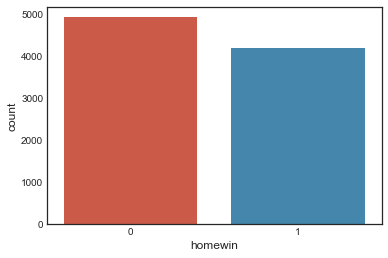

In [24]:
# view distribution of target variable
sns.countplot(x='homewin', data=full)

print(full['homewin'].mean()) # home team wins about 46% of the time.
# implies that baseline predictions (assume that homewin=0 for all matches) will have 54% accuracy.
# we want to build a predictive model that can outperform the baseline (i.e. exceed 54% accuracy)

In [25]:
##### complete

# check if object variables have missing values
for var in full.columns:
    if full[var].dtype=='object':
        print(var, 'has', full[var].isnull().sum(),'missing values')
print('-'*30)

# use mode to impute missing values for object variables
full['homeFormation'].fillna(full['homeFormation'].mode()[0], inplace = True)

# view the percentage of missing values for each variable
print((full.isnull().sum() / full.shape[0] * 100).sort_values(ascending=False)) # full.shape[0] returns the no. of rows
print('-'*30)

# use mean to impute missing values for numeric variables
for var in full.columns:
    if full[var].dtype=='int' or full[var].dtype=='float':
        full[var].fillna(full[var].mean(), inplace=True)

# verify that there are no more variables with missing values
print((full.isnull().sum()).sort_values(ascending=False))

homeFormation has 1 missing values
awayFormation has 0 missing values
division has 0 missing values
------------------------------
awayOffsidesCaughtFT       3.374603
awayOffsidesCaughtHT       3.374603
homeOffsidesCaughtHT       2.925386
homeOffsidesCaughtFT       2.925386
awayShotsBlockedFT         2.421387
awayShotsBlockedHT         2.421387
homeShotsBlockedHT         1.172346
homeShotsBlockedFT         1.172346
awayShotsOnTargetHT        0.635477
awayShotsOnTargetFT        0.635477
awayCornersTotalHT         0.558782
awayCornersTotalFT         0.558782
homeShotsOnTargetHT        0.262956
homeCornersTotalHT         0.262956
homeShotsOnTargetFT        0.262956
homeCornersTotalFT         0.262956
awayPassesKeyHT            0.054783
awayPassesKeyFT            0.054783
homeDribblesWonFT          0.032870
awayDribbledPastFT         0.032870
awayDribbledPastHT         0.032870
homeDribbleSuccessFT       0.032870
homeDribbleSuccessHT       0.032870
homeDribblesWonHT          0.032870
awayD

In [26]:
##### create

# create an int var showing the number of defenders in the home/away team
full['home_defenders'] = [int(str(x)[0:1]) for x in full['homeFormation']]
full['away_defenders'] = [int(str(x)[0:1]) for x in full['awayFormation']]
full = full.drop(['homeFormation','awayFormation'], axis=1)

# create a dummy for homeRatingsFT > awayRatingsFT
full['homeRatingsFT_higher']=0
full.loc[(full['homeRatingsFT']>full['awayRatingsFT']),'homeRatingsFT_higher']=1

# create a dummy for homeGoalHT > awayGoalHT
full['homeGoalHT_higher']=0
full.loc[(full['homeGoalHT']>full['awayGoalHT']),'homeGoalHT_higher']=1

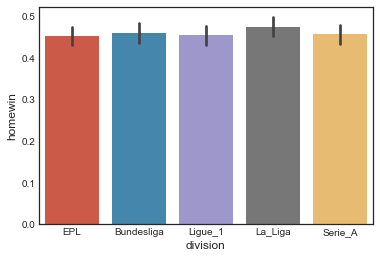

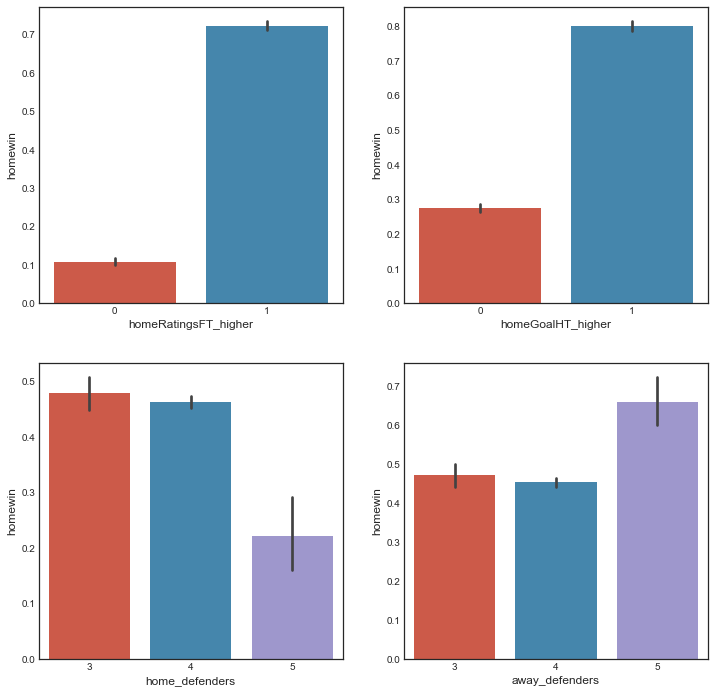

In [27]:
##### data visualizations

# plot homewin against division
sns.barplot(x='division', y='homewin', data=full) # homewin equally likely in Europe's top 5 divisions

# plot homewin against select variables
fig, saxis = plt.subplots(2,2,figsize=(12,12)) # to fit 2 rows and 2 columns worth of subplots in one plot
sns.barplot(x = 'homeRatingsFT_higher', y = 'homewin', data=full, ax = saxis[0][0]) # higher FT rating for home team = more likely homewin at FT
sns.barplot(x = 'homeGoalHT_higher', y = 'homewin', data=full, ax = saxis[0][1]) # more HT goals for home team = more likely homewin at FT
sns.barplot(x = 'home_defenders', y = 'homewin', data=full, ax = saxis[1][0]) # defensive home teams are less likely to win
sns.barplot(x = 'away_defenders', y = 'homewin', data=full, ax = saxis[1][1]) # defensive away teams are less likely to win


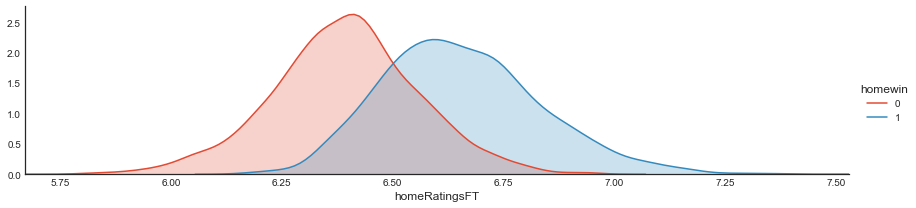

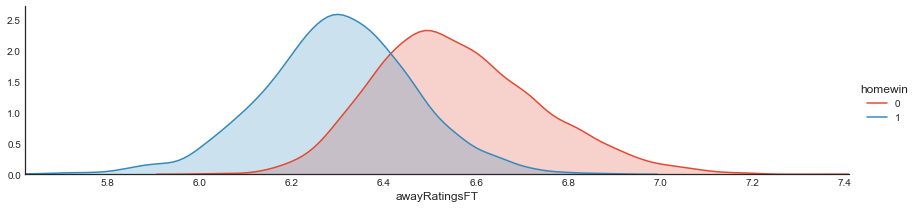

In [28]:
##### data visualizations (continued)

# let's see if the distribution of homeRatingsFT depends on homewin
a = sns.FacetGrid(full, hue='homewin', aspect=4 ) # use the dataset 'full', and plot one distribution per category of 'homewin'
a.map(sns.kdeplot, 'homeRatingsFT', shade= True ) # kernel density plot of homeRatingsFT
a.set(xlim=(full['homeRatingsFT'].min(), full['homeRatingsFT'].max())) # set the boundaries of x-axis
a.add_legend() # add a legend for the distributions

# do the same for awayRatingsFT
b = sns.FacetGrid(full, hue='homewin', aspect=4 ) # use the dataset 'full', and plot one distribution per category of 'homewin'
b.map(sns.kdeplot, 'awayRatingsFT', shade= True ) # kernel density plot of awayRatingsFT
b.set(xlim=(full['awayRatingsFT'].min(), full['awayRatingsFT'].max())) # set the boundaries of x-axis
b.add_legend() # add a legend for the distributions

In [29]:
##### convert

# one-hot encode categorical variables
full = pd.get_dummies(full)

# ensure all variables are numeric and non-missing
print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 88 columns):
homeTacklesTotalHT         9127 non-null int64
homeShotsTotalHT           9127 non-null int64
awayDispossessedFT         9127 non-null float64
awayPassSuccessFT          9127 non-null float64
awayRatingsFT              9127 non-null float64
awayDribbleSuccessFT       9127 non-null float64
awayDribblesAttemptedHT    9127 non-null int64
awayShotsBlockedHT         9127 non-null float64
awayShotsTotalHT           9127 non-null float64
homeDribbleSuccessHT       9127 non-null float64
homeFoulsCommitedFT        9127 non-null int64
homeAerialsTotalFT         9127 non-null int64
homeRatingsHT              9127 non-null float64
awayShotsOnTargetFT        9127 non-null float64
awayShotsBlockedFT         9127 non-null float64
homeInterceptionsHT        9127 non-null int64
awayPossessionHT           9127 non-null float64
homePassesKeyFT            9127 non-null int64
awayShotsOnTargetHT      

In [30]:
# split the cleaned full dataset into train and test datasets
from sklearn import model_selection
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(full.drop(['homewin'], axis=1), full['homewin'], test_size=0.3)

In [31]:
##### model building

### view k-fold cross-validation performance of model
from sklearn.ensemble import RandomForestClassifier

my_model1 = RandomForestClassifier(n_jobs = -1, # fully utilize the cores on your computer
                                   n_estimators = 250, # number of trees
                                   max_features = "sqrt", # number of features to consider at each split
                                   max_depth = 8) # maximum tree depth

cv_results = model_selection.cross_validate(my_model1,
                                            xtrain,
                                            ytrain,
                                            scoring='accuracy',
                                            cv = 10)

print("the mean training accuracy is:", cv_results['train_score'].mean())
print("the mean validation accuracy is:", cv_results['test_score'].mean())

the mean training accuracy is: 0.9035867780097426
the mean validation accuracy is: 0.833293985109718


In [32]:
##### use random search to optimize the hyperparameters, while building the optimal model concurrently
from scipy.stats import randint
from scipy.stats import uniform

param_dist = {'max_depth': randint(3,15),
              'n_estimators': [250],
              'max_features': ['sqrt']
             }

tune_model = model_selection.RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                                param_distributions=param_dist,
                                                scoring = "accuracy",
                                                cv = 10,
                                                n_iter = 10) # number of iterations of random search

tune_model.fit(xtrain, ytrain)

#print(tune_model.cv_results_['params'])
print('the optimized hyperparameters are: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("after optimization, the mean training MSE is: {:.4f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_])) 
#print(tune_model.cv_results_['mean_test_score'])
print("after optimization, the mean validation MSE is: {:.4f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]))

the optimized hyperparameters are:  {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 250}
after optimization, the mean training MSE is: 0.9858
after optimization, the mean validation MSE is: 0.8375


0.8535962029937934


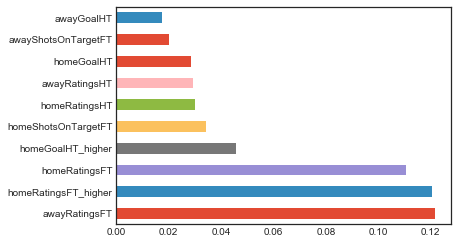

In [33]:
##### use optimized hyperparameters to build random forest
my_rf = RandomForestClassifier(n_jobs = -1, # fully utilize the cores on your computer
                               n_estimators = tune_model.best_params_['n_estimators'], # number of trees
                               max_features = tune_model.best_params_['max_features'], # number of features to consider at each split
                               max_depth = tune_model.best_params_['max_depth']) # maximum tree depth

# fit the random forest
rf_model1 = my_rf.fit(xtrain,ytrain)

# view feature importances
feature_importances = pd.Series(rf_model1.feature_importances_, index=xtrain.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance; for pandas dataframe sorting, refer to https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
feature_importances.nlargest(10).plot(kind='barh')

# use the fitted model to make predictions
rf_pred1 = rf_model1.predict(xtest)

# test dataset: compare predicted values to actual values
comparison_df = pd.DataFrame({'predicted_homewin': rf_pred1, 
                              'actual_homewin': ytest})
comparison_df['correct_prediction']=0
comparison_df.loc[(comparison_df['predicted_homewin']==comparison_df['actual_homewin']),'correct_prediction']=1
print(comparison_df['correct_prediction'].mean()) # much better accuracy than baseline model